In [1]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-cp8bfvoo
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-cp8bfvoo
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=e868bd29d9df76f2ea3b9ee9c1f5ab8a7783fdf29ee0ed1251e74fc6a59e22b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-gxbbj3qz/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
cr

In [2]:
%%cu 
#include<stdio.h>
#define DIM 1000
struct cuComplex{
    float r;
    float i;
    __device__ cuComplex(float a, float b):r(a),i(b){}
    __device__ float magnitude2(void){ return r*r+i*i; }
    __device__ cuComplex operator*(const cuComplex &a){ return cuComplex(r*a.r-i*a.i,i*a.r+r*a.i); }
    __device__ cuComplex operator+(const cuComplex &a){ return cuComplex(r+a.r,i+a.i); }
};
__device__ int julia(int x, int y){
    const float scale=1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(-0.8,0.156);
    cuComplex a(jx,jy);
    int i=0;
    for(i=0;i<200;i++){
        a=a*a+c;
        if(a.magnitude2()>1000) return 0;
    }
    return 1;
}
__global__ void kernel(unsigned char *ptr){
    int x=blockIdx.x;
    int y=blockIdx.y;
    int offset=x+y*gridDim.x;

    int juliaValue=julia(x,y);
    ptr[offset*4+0]=255*juliaValue;
    ptr[offset*4+1]=0;
    ptr[offset*4+2]=0;
    ptr[offset*4+3]=255;
}
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}
void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_GPU.jpg","w");
    fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
     for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
}
fclose(fp);
}
int main(void){
    clock_t start, end;
    double execution_time1;
    FILE *fp = fopen("execution_time1.txt", "w");
    for (int i = 0; i < 10; i++) {
        start = clock();
        DataBlock data;
        unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
        int image_size = DIM*DIM*4;
        unsigned char *dev_bitmap;
        cudaMalloc((void**)&dev_bitmap, image_size);
        data.dev_bitmap=dev_bitmap;
        dim3 grid(DIM,DIM);
        kernel<<<grid,1>>>(dev_bitmap);
        cudaMemcpy(bitmap,dev_bitmap,image_size,cudaMemcpyDeviceToHost);
        cudaFree(dev_bitmap);
        save_to_file (bitmap);
        end = clock();
            execution_time1 = ((double)(end - start))/CLOCKS_PER_SEC;
            fprintf(fp, "%f\n", execution_time1);
        }
        fclose(fp);
        return 0;
}

In [3]:
%%cu 
#include<stdio.h>
#define DIM 500
struct cuComplex{
    float r;
    float i;
    __device__ cuComplex(float a, float b):r(a),i(b){}
    __device__ float magnitude2(void){ return r*r+i*i; }
    __device__ cuComplex operator*(const cuComplex &a){ return cuComplex(r*a.r-i*a.i,i*a.r+r*a.i); }
    __device__ cuComplex operator+(const cuComplex &a){ return cuComplex(r+a.r,i+a.i); }
};
__device__ int julia(int x, int y){
    const float scale=1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(-0.8,0.156);
    cuComplex a(jx,jy);
    int i=0;
    for(i=0;i<200;i++){
        a=a*a+c;
        if(a.magnitude2()>1000) return 0;
    }
    return 1;
}
__global__ void kernel(unsigned char *ptr){
    int x=blockIdx.x;
    int y=blockIdx.y;
    int offset=x+y*gridDim.x;

    int juliaValue=julia(x,y);
    ptr[offset*4+0]=255*juliaValue;
    ptr[offset*4+1]=0;
    ptr[offset*4+2]=0;
    ptr[offset*4+3]=255;
}
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}
void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_GPU.jpg","w");
    fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
     for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
}
fclose(fp);
}
int main(void){
    clock_t start, end;
    double execution_time1_1;
    FILE *fp = fopen("execution_time1_1.txt", "w");
    for (int i = 0; i < 10; i++) {
        start = clock();
        DataBlock data;
        unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
        int image_size = DIM*DIM*4;
        unsigned char *dev_bitmap;
        cudaMalloc((void**)&dev_bitmap, image_size);
        data.dev_bitmap=dev_bitmap;
        dim3 grid(DIM,DIM);
        kernel<<<grid,1>>>(dev_bitmap);
        cudaMemcpy(bitmap,dev_bitmap,image_size,cudaMemcpyDeviceToHost);
        cudaFree(dev_bitmap);
        save_to_file (bitmap);
        end = clock();
            execution_time1_1 = ((double)(end - start))/CLOCKS_PER_SEC;
            fprintf(fp, "%f\n", execution_time1_1);
        }
        fclose(fp);
        return 0;
}


In [4]:
%%cu 
#include<stdio.h>
#define DIM 1000

struct cuComplex{
    float r;
    float i;
    cuComplex(float a, float b):r(a),i(b){}
    float magnitude2(void){return r*r+i*i;}
    cuComplex operator*(const cuComplex &a){ return cuComplex(r*a.r-i*a.i,i*a.r+r*a.i); }
    cuComplex operator+(const cuComplex &a){ return cuComplex(r+a.r,i+a.i); }
};
    int julia(int x, int y){
    const float scale=1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(-0.8,0.156);
    cuComplex a(jx,jy);
    int i=0;
    for(i=0;i<200;i++){
        a=a*a+c;
        if(a.magnitude2()>1000) return 0;
    }
    return 1;
}
    void kernel(unsigned char *ptr){
        for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            int juliaValue=julia(x,y);
            ptr[offset*4+0]=255*juliaValue;
            ptr[offset*4+1]=0;
            ptr[offset*4+2]=0;
            ptr[offset*4+3]=255;
          }
        }
    }
  
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}
void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_CPU.jpg","w");
    fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
     for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
}
fclose(fp);
}
int main(void){
    clock_t start, end;
    double execution_time2;
    FILE *fp = fopen("execution_time2.txt", "w");
    for (int i = 0; i < 10; i++) {
        start = clock();
        DataBlock data;
        unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
        int image_size = DIM*DIM*4;
        kernel(bitmap);
        save_to_file (bitmap);
        end = clock();
        execution_time2 = ((double)(end - start))/CLOCKS_PER_SEC;
        fprintf(fp, "%f\n", execution_time2);
    }
    fclose(fp);
    return 0;
}


In [5]:
%%cu 
#include<stdio.h>
#define DIM 500

struct cuComplex{
    float r;
    float i;
    cuComplex(float a, float b):r(a),i(b){}
    float magnitude2(void){return r*r+i*i;}
    cuComplex operator*(const cuComplex &a){ return cuComplex(r*a.r-i*a.i,i*a.r+r*a.i); }
    cuComplex operator+(const cuComplex &a){ return cuComplex(r+a.r,i+a.i); }
};
    int julia(int x, int y){
    const float scale=1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(-0.8,0.156);
    cuComplex a(jx,jy);
    int i=0;
    for(i=0;i<200;i++){
        a=a*a+c;
        if(a.magnitude2()>1000) return 0;
    }
    return 1;
}
    void kernel(unsigned char *ptr){
        for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            int juliaValue=julia(x,y);
            ptr[offset*4+0]=255*juliaValue;
            ptr[offset*4+1]=0;
            ptr[offset*4+2]=0;
            ptr[offset*4+3]=255;
          }
        }
    }
  
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}
void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_CPU.jpg","w");
    fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
     for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
}
fclose(fp);
}
int main(void){
    clock_t start, end;
    double execution_time2_2;
    FILE *fp = fopen("execution_time2_2.txt", "w");
    for (int i = 0; i < 10; i++) {
        start = clock();
        DataBlock data;
        unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
        int image_size = DIM*DIM*4;
        kernel(bitmap);
        save_to_file (bitmap);
        end = clock();
        execution_time2_2 = ((double)(end - start))/CLOCKS_PER_SEC;
        fprintf(fp, "%f\n", execution_time2_2);
    }
    fclose(fp);
    return 0;
}


In [6]:

!apt-get install gnuplot
!pip install matplotlib


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aglfn gnuplot-data gnuplot-qt libgail-common libgail18 libgtk2.0-0
  libgtk2.0-bin libgtk2.0-common liblua5.3-0 libnotify4 libqt5svg5
  libwxbase3.0-0v5 libwxgtk3.0-0v5 notification-daemon
Suggested packages:
  gnuplot-doc gvfs
The following NEW packages will be installed:
  aglfn gnuplot gnuplot-data gnuplot-qt libgail-common libgail18 libgtk2.0-0
  libgtk2.0-bin libgtk2.0-common liblua5.3-0 libnotify4 libqt5svg5
  libwxbase3.0-0v5 libwxgtk3.0-0v5 notification-daemon
0 upgraded, 15 newly installed, 0 to remove and 21 not upgraded.
Need to get 8,566 kB of archives.
After this operation, 31.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libqt5sv

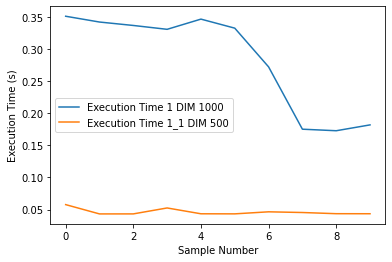

In [7]:
import matplotlib.pyplot as plt

# Read data from files
execution_time1 = []
with open("execution_time1.txt", "r") as file:
    for line in file:
        execution_time1.append(float(line.strip()))

execution_time2 = []
with open("execution_time1_1.txt", "r") as file:
    for line in file:
        execution_time2.append(float(line.strip()))

# Create a line plot
plt.plot(execution_time1, label="Execution Time 1 DIM 1000")
plt.plot(execution_time2, label="Execution Time 1_1 DIM 500")
plt.xlabel("Sample Number")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.show()

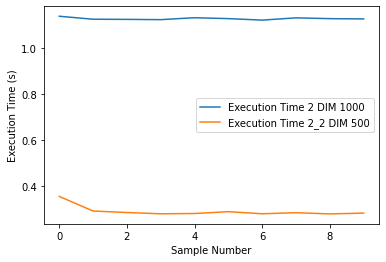

In [8]:
import matplotlib.pyplot as plt

# Read data from files
execution_time1 = []
with open("execution_time2.txt", "r") as file:
    for line in file:
        execution_time1.append(float(line.strip()))

execution_time2 = []
with open("execution_time2_2.txt", "r") as file:
    for line in file:
        execution_time2.append(float(line.strip()))

# Create a line plot
plt.plot(execution_time1, label="Execution Time 2 DIM 1000")
plt.plot(execution_time2, label="Execution Time 2_2 DIM 500")
plt.xlabel("Sample Number")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.show()
